#**오픈소스 팀 과제 - BERT를 활용한 대화 이진 분류 - 전유정**

허깅페이스(Hugging Face)에서 제공하는 transformer 라이브러리를 활용하여 한국어 BERT로 텍스트 대화 중에서 성적인 텍스트를 분류해보도록 하겠습니다.

1.1. 사용한 데이터
- 텍스트 윤리 검정 데이터
https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=558

1.2. 데이터셋 구조
총 44,998개의 데이터로 총 5개의 라벨로 이루어져 있습니다.
 - 일반 대화와 성적 대화만 추출
 - 데이터 결측치 제거
 - Okt 라이브러리를 활용한 토큰화
다음과 같은 과정을 통해 데이터 전처리를 진행하였으며, 최종 21,740개의 데이터로 간소화 하였으며, 라벨도 2개로 단축시켰습니다. + 성적인 대화의 수가 적어 정확성이 높지 않은 경우를 고려하여, 성적인 데이터셋을 학습 데이터로 추가시켰습니다.

2. 모델 학습

 2.1. 훈련-테스트 데이터 분할
2만 개의 데이터도 적은 수는 아니나 더 다양한 케이스를 학습하기 위해 20%를 test 데이터로 구분했습니다.

 2.2. BERT 토크나이저 불러오기

 2.3. DataLoader 구성

 2.4. BERT 모델 불러오기

 2.5. 모델 훈련

In [ ]:
!pip install pandas
!pip install numpy
!pip install pillow
!pip install konlpy
!pip install wordcloud

In [ ]:

!pip install konlpy

In [ ]:
import pandas as pd

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Hannanum
from PIL import Image
import numpy as np

In [ ]:
df = pd.read_csv("test", sep='\t', header=None)

In [ ]:
df.shape
df.sample(n=10)
total_rows, total_columns = df.shape
print(f"총 {total_rows}줄 x {total_columns} 열")
df.sample(n=10)

총 44998줄 x 6 열


,0,1,2,3,4,5
25139,3,False,0.0,1,IMMORAL_NONE,부러워서 나도 트레이너가 꿈으로 바꿨어
32849,5,False,0.0,1,IMMORAL_NONE,상대한테 해주려고?
32149,3,True,1.0,2,CENSURE,집에서 니가 하는게 없으면 그런거라도 알아서 해라
37839,1,False,0.0,1,IMMORAL_NONE,저 사람을 뽑으면 나라가 잘 변화될 수 있을까?
18111,2,False,0.0,2,IMMORAL_NONE,나 그렇게 심해..?
35410,2,True,2.0,2,SEXUAL,오 그게 말로만 듣던 오피녀인 건가?
35796,2,True,1.4,2,CENSURE,어휴 ㅋㅋㅋ 이래서 공익들이 까여야 하는거야
20342,3,False,0.0,1,IMMORAL_NONE,내가 무슨 짐승이니?
43018,1,False,0.0,1,IMMORAL_NONE,<이름>이 선거 때 말만 안 바꾸면 좋을텐데
2757,2,True,1.4,2,CENSURE,하라는 수업은 안하고 틀니만 딱딱거림


섹슈얼 데이터 csv (test 데이터)



In [ ]:
# 성적 대화 데이터만 추출
sexual_df = df[df[4].str.contains("SEXUAL")]

# 대화 유형과 텍스트 메세지만 추출
selected_df = sexual_df.iloc[:, [4, 5]]

# CSV로 저장
selected_df.to_csv("selected_data.csv", index=False, header=None)

일상 대화 데이터 csv (test 데이터)

In [ ]:
# 일상 대화만 추출
moral_df = df[df[4].str.contains("IMMORAL_NONE")]

# 대화 유형과 텍스트 메세지만 추출
moral_selected_df = moral_df.iloc[:, [4, 5]]

# CSV로 저장
moral_selected_df.to_csv("moral_selected_data.csv", index=False, header=None)

섹슈얼 데이터 + 일상 대화 데이터 csv화 (test 데이터)

In [ ]:
merged_df = pd.concat([moral_selected_df, selected_df])
merged_df.to_csv("test_data.csv", index=False, header=None)
print(merged_df)

                    4                                              5
0        IMMORAL_NONE                       <마미손> 이번에 해명 영상 올렸던데 봤어?
1        IMMORAL_NONE                           어 <염따> 제대로 큰일 난거 같던데
3        IMMORAL_NONE                             요즘 같은 시대에 모솔이 가능해?
4        IMMORAL_NONE                           흐음 글쎄.. 그럴 수도 있지, 뭐.
6        IMMORAL_NONE                  어제 교수가 지 자식 볼 책 도서관에서 빌료오라고 함
...               ...                                            ...
44933     HATE,SEXUAL                  벌레 같은 것들이 다시 니들 엄마 자궁으로 들어가;;
44945          SEXUAL  어디서 몸굴리던 개버릇 남 못준다고 지금도 더럽게 몸 섞으면서 돈 벌고 있을 수도
44946          SEXUAL                             역시 한국 여자답게 잘 벌리는 듯
44992  SEXUAL,CENSURE                           밋틴건가... 차라리 다 벗지 ㅋㅋㅋ
44993  SEXUAL,CENSURE                                  ㄱㅊ도 걍 내놓고 다녀~

[21740 rows x 2 columns]


 섹슈얼 데이터 (train 데이터 = 모델 학습 데이터)

In [ ]:
train_df = pd.read_csv("train", sep='\t', header=None)

In [ ]:
print(train_df)

        0      1    2  3             4  \
0       1   True  2.0  1       CENSURE   
1       2   True  2.0  2       CENSURE   
2       3   True  2.0  1       CENSURE   
3       4   True  2.0  2       CENSURE   
4       1   True  1.0  1       CENSURE   
...    ..    ...  ... ..           ...   
348068  1  False  0.0  1  IMMORAL_NONE   
348069  2  False  0.0  2  IMMORAL_NONE   
348070  1  False  0.0  1  IMMORAL_NONE   
348071  3  False  0.0  2  IMMORAL_NONE   
348072  2  False  0.0  2  IMMORAL_NONE   

                                              5  
0                   부랴부랴 왔는데 아무도 안왔네. 시간개념들이 없네  
1                             맞아. 사람들이 진짜 개념이없다  
2                                  저렇게는 살지 말아야지  
3                        그러게 게으르고 멍청한 사람들은 맞아야해  
4                             인방 보는 남자는 거르는게 맞다  
...                                         ...  
348068                              나는 매일 죽고 싶어  
348069                 시한부도 열심히 사는데 너가 그러면 안 되지  
348070  애들이 똑똑해지긴 했는데 문제는 무식한 애들한테도 스마트폰이 생긴 

In [ ]:
# NaN 값 제거
t_sexual_df = train_df.dropna(subset=[4]).copy()

# 섹슈얼 데이터만 추출
t_sexual_df = t_sexual_df[t_sexual_df[4].str.contains("SEXUAL")]

# 대화 유형과 텍스트 메세지만 추출
t_selected_df = t_sexual_df.iloc[:, [4, 5]]

# CSV로 저장
t_selected_df.to_csv("t_train_df_selected_data.csv", index=False, header=None)
print()


In [ ]:
# NaN 값 제거
t_moral_df = train_df.dropna(subset=[4]).copy()

# 일상 대화만 추출
t_moral_df = t_moral_df[t_moral_df[4].str.contains("IMMORAL_NONE")]

# 대화 유형과 텍스트 메세지만 추출
t_moral_selected_df = t_moral_df.iloc[:, [4, 5]]

# CSV로 저장
t_moral_selected_df.to_csv("t_selected_data.csv", index=False, header=None)

In [ ]:
t_merged_df = pd.concat([t_moral_selected_df, t_selected_df])
t_merged_df.to_csv("t_test_data.csv", index=False, header=None)
print(t_merged_df)

                           4                                  5
10              IMMORAL_NONE                쉴드가 아니라 국가가 면제해준거야.
17              IMMORAL_NONE                      짐승입장도 들어봐야지ㅋㅋ
19              IMMORAL_NONE                  <이름>이 이제 급하긴 한가보네
20              IMMORAL_NONE                     깐부라고 부르기까지 하다니
22              IMMORAL_NONE        어머니 간 이식 해 주기 싫어서 도망쳤다고...?
...                      ...                                ...
347962  CENSURE,ABUSE,SEXUAL     뭐만 하면 힘들데 그냥 집가서 엄마한테 젖도 달라고 해
347972        CENSURE,SEXUAL        염소 뷰지가 로린이 뷰지랑 제일 비슷하다고 했나?
348002   CENSURE,HATE,SEXUAL  아무리 길어봐야 한8년유지하다 애2~3명까낳고 이혼크리밟을듯
348011                SEXUAL                       그냥 임신공격해 ㅋㅋㅋ
348037                SEXUAL         물고 빠는 거 달인이라 이런 거 스킵 가능임ㅋㅋ

[174033 rows x 2 columns]


In [ ]:
!pip install torchtext==0.6.0

In [ ]:
from konlpy.tag import Okt
import re
import pandas as pd
from IPython.display import display, HTML

# 섹슈얼 데이터만 추출한 데이터프레임인 sexual_df가 이미 생성되어 있다고 가정합니다.
# 여기에 대해 전처리 작업을 수행하겠습니다.

# 형태소 분석기 초기화
tokenizer = Okt()

# 텍스트 전처리 함수
def preprocess_text(text):
    # 특수문자 및 반복적인 문자 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    # "ㅋㅋ, ㅎㅎ"와 같은 특정한 문자열 패턴 제거
    text = re.sub(r'ㅋ+', '', text)
    text = re.sub(r'ㅎ+', '', text)
    text = re.sub(r'ㅠ+', '', text)
    text = re.sub(r'ㅡㅡ', '', text)
    text = re.sub(r'(.)\1+', r'\1\1', text)  # 반복적인 문자 축약
    # 형태소 분석 및 불용어 처리
    morphs = tokenizer.morphs(text)
    stopwords = ['의','가','에','들','는','잘','걍','과','도','를','으로','한','하다', '히', '힣', '흠', '!','?','<','>','(',')','[',']','|','#','.']
    filtered_morphs = [word for word in morphs if not word in stopwords]
    return filtered_morphs

# 2번째 열 선택 (대화 텍스트)
text_column = merged_df.iloc[:, 1]

# 열을 문자열로 변환
text_column_str = text_column.astype(str)

# 텍스트 전처리 적용
preprocessed_text_column = text_column_str.apply(preprocess_text)

# 1번째 열 선택 (moral, sexual 라벨)
id_column = merged_df.iloc[:, 0]

# 1번째 열의 라벨 변환
id_column = id_column.apply(lambda x: 0 if x == 'IMMORAL_NONE' else 1)

# 1번째 열과 2번째 열 (라벨, 텍스트) 합쳐서 하나로 반환
result_df = pd.concat([id_column, preprocessed_text_column], axis=1)

# CSV로 저장
result_df.to_csv("result_df.csv", index=False, header=None)

# 데이터의 처음 5줄과 끝 5줄 추출
first_five = result_df.head(4)
last_five = result_df.tail(5)

# 처음 5줄과 끝 5줄을 하나의 데이터프레임으로 결합
combined_df = pd.concat([first_five, last_five])

# 데이터의 총 행 수와 열 수
total_rows, total_columns = result_df.shape

# 데이터프레임 출력 (HTML 테이블로 변환)
display(HTML(combined_df.to_html(index=False, header=["Label", "Processed Text"])))

# 총 행과 열 수 출력 (테이블 형식)
print(f"총 {total_rows}줄 x {total_columns} 열")


4,5
0,"[마미, 손, 이번, 해명, 영상, 올렸던데, 봤어]"
0,"[어, 염따, 제대로, 큰일, 난거, 같던데]"
0,"[요즘, 같은, 시대, 모, 솔이, 가능해]"
0,"[흐음, 글쎄, 그럴, 수도, 있지, 뭐]"
1,"[벌레, 같은, 것, 이, 다시, 니, 엄마, 자궁, 들어가]"
1,"[어디서, 몸, 굴리, 던, 개, 버릇, 남, 못, 준다고, 지금, 더럽게, 몸, 섞으면서, 돈, 벌고, 있을, 수도]"
1,"[역시, 한국, 여자, 답, 게, 벌리는, 듯]"
1,"[밋틴건, 차라리, 다, 벗지]"
1,"[ㄱㅊ, 내놓고, 다녀]"


총 21740줄 x 2 열


In [ ]:
from konlpy.tag import Okt
import re
import pandas as pd

# 섹슈얼 데이터만 추출한 데이터프레임인 sexual_df가 이미 생성되어 있다고 가정합니다.
# 여기에 대해 전처리 작업을 수행하겠습니다.

# 형태소 분석기 초기화
tokenizer = Okt()

# 텍스트 전처리 함수
def preprocess_text(text):
    # 특수문자 및 반복적인 문자 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    # "ㅋㅋ, ㅎㅎ"와 같은 특정한 문자열 패턴 제거
    text = re.sub(r'ㅋ+', '', text)
    text = re.sub(r'ㅎ+', '', text)
    text = re.sub(r'ㅠ+', '', text)
    text = re.sub(r'ㅡㅡ', '', text)
    text = re.sub(r'(.)\1+', r'\1\1', text)  # 반복적인 문자 축약
    # 형태소 분석 및 불용어 처리
    morphs = tokenizer.morphs(text)
    stopwords = ['의','가','에','들','는','잘','걍','과','도','를','으로','한','하다', '히', '힣', '흠', '!','?','<','>','(',')','[',']','|','#','.']
    filtered_morphs = [word for word in morphs if not word in stopwords]
    return filtered_morphs

# 2번째 열 선택 (대화 텍스트)
t_text_column = t_merged_df.iloc[:, 1]

# 열을 문자열로 변환
t_text_column_str = t_text_column.astype(str)

# 텍스트 전처리 적용
t_preprocessed_text_column = t_text_column_str.apply(preprocess_text)

# 1번째 열 선택 (moral, sexual 라벨)
t_id_column = t_merged_df.iloc[:, 0]

# 1번째 열과 2번째 열 (라벨, 텍스트) 합쳐서 하나로 반환
t_result_df = pd.concat([t_id_column, t_preprocessed_text_column], axis=1)

# CSV로 저장
t_result_df.to_csv("t_result_df.csv", index=False, header=None)
print(t_result_df)

                           4  \
10              IMMORAL_NONE   
17              IMMORAL_NONE   
19              IMMORAL_NONE   
20              IMMORAL_NONE   
22              IMMORAL_NONE   
...                      ...   
347962  CENSURE,ABUSE,SEXUAL   
347972        CENSURE,SEXUAL   
348002   CENSURE,HATE,SEXUAL   
348011                SEXUAL   
348037                SEXUAL   

                                                        5  
10                                [쉴드, 아니라, 국가, 면제, 해준거야]  
17                                      [짐승, 입장, 들어, 봐야지]  
19                                [이름, 이, 이제, 급하긴, 가보, 네]  
20                                 [깐, 부라, 고, 부르기까지, 하다니]  
22                        [어머니, 간, 이식, 해, 주기, 싫어서, 도망쳤다고]  
...                                                   ...  
347962     [뭐, 만, 하면, 힘들데, 그냥, 집가서, 엄마, 한테, 젖도, 달라, 고, 해]  
347972            [염소, 뷰, 지, 로린, 이, 뷰, 지랑, 제일, 비슷하다고, 했나]  
348002  [아무리, 길어, 봐야, 8년, 유지하다, 애, 23, 명, 까, 낳고, 이혼, 크...  
348011         

In [ ]:
import json

# 모든 토큰을 담을 집합 생성
token_set = set()

# 전처리된 텍스트 데이터로부터 모든 토큰을 추출하여 집합에 추가
for tokens in preprocessed_text_column:
    token_set.update(tokens)

# 토큰과 인덱스를 매핑할 딕셔너리 생성
token_to_index = {token: idx for idx, token in enumerate(sorted(token_set))}

# 데이터 사전을 JSON 파일로 저장
with open('sexual_dictionary.json', 'w', encoding='utf-8') as f:
    json.dump(token_to_index, f, ensure_ascii=False, indent=4)


BERT 모델링


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['text']
        label = self.dataframe.iloc[idx]['label']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True,
            return_token_type_ids=False,
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
from sklearn.model_selection import train_test_split

# 데이터 로드 및 전처리
train_data = pd.read_csv("t_test_data.csv", header=None)
train_data.columns = ['label', 'text']
train_data['label'] = train_data['label'].apply(lambda x: 0 if x == 'IMMORAL_NONE' else 1)

# 데이터를 훈련과 검증 데이터셋으로 분할
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_data, tokenizer, max_length=128)
val_dataset = CustomDataset(val_data, tokenizer, max_length=128)

# 데이터로더 생성 (셔플링 수행)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 모델 정의
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

# 옵티마이저 및 스케줄러 설정
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
for i in range(5):  # 예시로 첫 5개 샘플 출력
    sample = train_dataset[i]

    print(f"Sample {i + 1}:\n")
    print("Input IDs:", sample['input_ids'], "\n")
    print("Attention Mask:", sample['attention_mask'], "\n")
    print("Label:", sample['label'], "\n")


Sample 1:

Input IDs: tensor([   101,   9283,  69023,  11287,    100,   9290,  14523,   9367,  48599,
         30873, 119210,  16439,    119,    102,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,   

Epoch 1 - Batch 0/8702 - Loss: 0.6047435402870178
Epoch 1 - Batch 500/8702 - Loss: 0.26693448424339294
Epoch 1 - Batch 1000/8702 - Loss: 0.1712663620710373
Epoch 1 - Batch 1500/8702 - Loss: 0.21717405319213867
Epoch 1 - Batch 2000/8702 - Loss: 0.11060171574354172
Epoch 1 - Batch 2500/8702 - Loss: 0.395502507686615
Epoch 1 - Batch 3000/8702 - Loss: 0.2647757828235626
Epoch 1 - Batch 3500/8702 - Loss: 0.33867278695106506
Epoch 1 - Batch 4000/8702 - Loss: 0.42207732796669006
Epoch 1 - Batch 4500/8702 - Loss: 0.2536919116973877
Epoch 1 - Batch 5000/8702 - Loss: 0.21541905403137207
Epoch 1 - Batch 5500/8702 - Loss: 0.035854678601026535
Epoch 1 - Batch 6000/8702 - Loss: 0.29133784770965576
Epoch 1 - Batch 6500/8702 - Loss: 0.08034121990203857
Epoch 1 - Batch 7000/8702 - Loss: 0.13138097524642944
Epoch 1 - Batch 7500/8702 - Loss: 0.289703905582428
Epoch 1 - Batch 8000/8702 - Loss: 0.332068532705307
Epoch 1 - Batch 8500/8702 - Loss: 0.06801948696374893
Epoch 1 - Avg. Loss: 0.18679321139970193


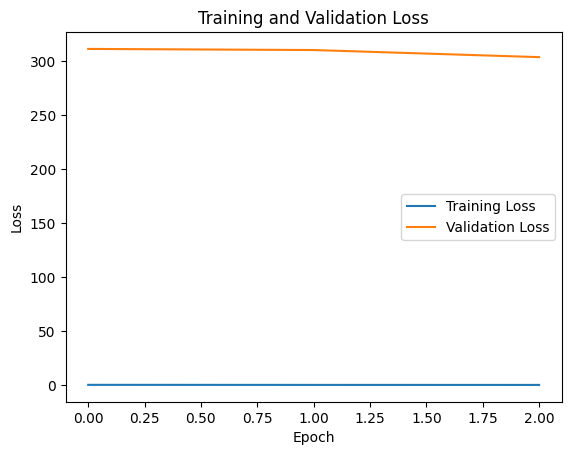

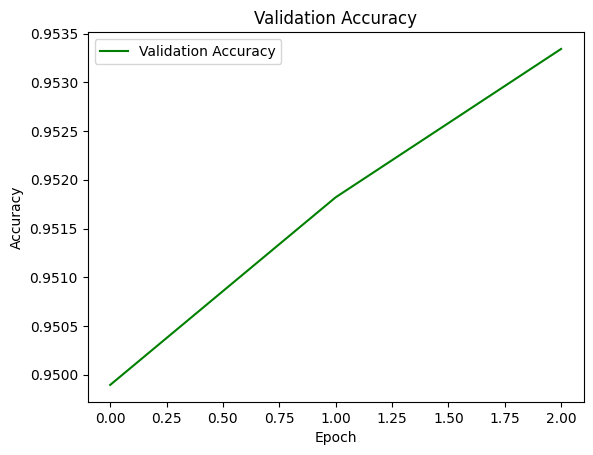

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 손실 기록
train_losses = []
val_losses = []
val_accuracies = []  # 정확도 기록


epochs = 5

# 학습
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward 수행
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        # 로스 구함
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 배치 진행 상황 출력
        if step % 500 == 0:
            print(f'Epoch {epoch + 1} - Batch {step}/{len(train_dataloader)} - Loss: {loss.item()}')

    # 에폭별 평균 손실 출력
    avg_loss = total_loss / len(train_dataloader)
    print("Epoch {} - Avg. Loss: {}".format(epoch + 1, avg_loss))
    train_losses.append(avg_loss)

    # 검증
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            val_loss += loss.item()
            val_preds.extend(logits.argmax(dim=1).tolist())
            val_labels.extend(labels.tolist())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print("Validation Accuracy:", val_accuracy)
    val_accuracies.append(val_accuracy)

    # 검증 손실 기록
    val_losses.append(val_loss)

# 손실 그래프 그리기
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 정확도 그래프 그리기
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


테스트 loss를 줄이기 위해서 바꿔본 점은 다음과 같습니다.

1. 데이터셋 수 감소 (train set을 80%로 감소)
2. 에폭 수 감소 (5 -> 3)
3. 기존 코드에서는 BERT 모델을 직접 구현하는 대신, 사전 학습된 BERT 모델을 불러왔음 -> BertForSequenceClassification 클래스를 사용하여 사전 학습된 BERT 모델과 분류 레이어를 함께 초기화해봄.  


-> 에폭을 너무 줄이니 정확한 예측 불가능 에폭을 5로 하되 , 데이터 전처리를 더 진행할 예정


In [ ]:
!pip install konlpy


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# BERT 모델과 토크나이저 불러오기
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# GPU를 사용할 수 있다면 GPU로 모델을 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 새로운 텍스트를 분류하는 함수 정의
def classify_text(text):
    # 전처리: 텍스트를 BERT 모델의 입력 형식으로 변환
    encoded_text = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    # 모델 추론
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probabilities).item()  # 가장 높은 확률을 가진 클래스 선택

    return predicted_class

# 새로운 텍스트 입력
new_text = "와 저 여자 앞뒤가 똑같아 ㅋㅋㅋㅋㅋ"
# 텍스트 분류 결과 출력
classification_result = classify_text(new_text)
if classification_result == 1:
    print("이 문장은 성적인 내용을 담고 있습니다.")
else:
    print("이 문장은 성적인 내용을 담고 있지 않습니다.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


이 문장은 성적인 내용을 담고 있지 않습니다.


In [ ]:
# 새로운 텍스트 입력
new_text = "나 어제 성매매 하고 왔다"
# 텍스트 분류 결과 출력
classification_result = classify_text(new_text)
if classification_result == 1:
    print("이 문장은 성적인 내용을 담고 있습니다.")
else:
    print("이 문장은 성적인 내용을 담고 있지 않습니다.")

이 문장은 성적인 내용을 담고 있습니다.


In [ ]:
# 모델 저장 경로 설정
model_path = 'Sexualexpression_model'

# 모델 저장
torch.save(model.state_dict(), model_path)

print("모델이 저장되었습니다:", model_path)


모델이 저장되었습니다: Sexualexpression_model
